In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
print(mnist.keys())

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


In [2]:
X, y = mnist['data'].values, mnist['target'].values
print(X.shape, y.shape)

(70000, 784) (70000,)


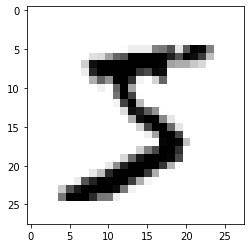

5


In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap='binary')
plt.show()
print(y[0])

In [4]:
import numpy as np
# cast targets to integers
y = y.astype(np.uint8)
print(y)

[5 0 4 ... 4 5 6]


In [5]:
Xtrain, Xtest, ytrain, ytest = X[:60000], X[60000:], y[:60000], y[60000:]
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

(60000, 784) (10000, 784) (60000,) (10000,)


In [6]:
# Train a binary classifier for detecting just the number 5
ytrain5 = (ytrain == 5) # vector that is true for all corresponding targets that equal 5 and false otherwise (cool operator)
ytest5 = (ytest == 5)
print(ytrain5[:20], ytrain[:20])

[ True False False False False False False False False False False  True
 False False False False False False False False] [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]


In [8]:
# stochastic gradient descent classifier
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(Xtrain, ytrain5)

print(sgd_clf.predict([some_digit]))

[ True]


In [9]:
# Evaluating performance using accuracy (bad metric because only 10% of data sets are 5s)
from sklearn.model_selection import cross_val_score
print(cross_val_score(sgd_clf, Xtrain, ytrain5, cv=3, scoring='accuracy'))

[0.95035 0.96035 0.9604 ]


In [10]:
# demonstrate that this classifier that always predicts false has above 90% accuracy
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never5clf = Never5Classifier()
print(cross_val_score(never5clf, Xtrain, ytrain5, cv=3, scoring='accuracy'))

[0.91125 0.90855 0.90915]


In [12]:
# gather predictions with kfolds and use to gen confusion matrix
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, Xtrain, ytrain5, cv=3)
print(y_train_pred.shape)

(60000,)


In [17]:
from sklearn.metrics import confusion_matrix
m = confusion_matrix(ytrain5, y_train_pred)
print(confusion_matrix(ytrain5, y_train_pred))

[[53892   687]
 [ 1891  3530]]


In [18]:
# Perfect results matrix
print(confusion_matrix(ytrain5, ytrain5))

[[54579     0]
 [    0  5421]]


In [19]:
print('accuracy or precision', m[1][1] / (m[0][1] + m[1][1]))
print('recall', m[1][1] / (m[1][0] + m[1][1]))

accuracy or precision 0.8370879772350012
recall 0.6511713705958311


In [20]:
# or from sklearn
from sklearn.metrics import precision_score, recall_score
print(precision_score(ytrain5, y_train_pred))
print(recall_score(ytrain5, y_train_pred))

0.8370879772350012
0.6511713705958311


In [22]:
# harmonic mean n / (sum(1/X))
print('f1 score', m[1][1] / (m[1][1] + ((m[0][1] + m[1][0]) / 2)))
# or with sklearn
from sklearn.metrics import f1_score
print(f1_score(ytrain5, y_train_pred))

f1 score 0.7325171197343847
0.7325171197343846


In [24]:
y_scores = cross_val_predict(sgd_clf, Xtrain, ytrain5, cv=3, method='decision_function')
print(y_scores)

[  1200.93051237 -26883.79202424 -33072.03475406 ...  13272.12718981
  -7258.47203373 -16877.50840447]


[0.09035    0.09035151 0.09035301 ... 1.         1.         1.        ]
[1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 3.68935621e-04
 1.84467810e-04 0.00000000e+00]
[-146348.56726174 -142300.00705404 -137588.97581744 ...   38871.26391927
   42216.05562787   49441.43765905]


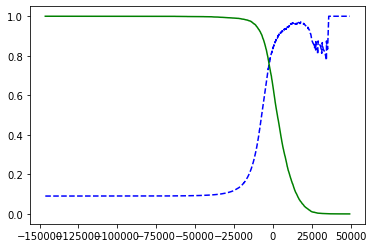

In [29]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(ytrain5, y_scores)
print(precisions)
print(recalls)
print(thresholds)

def plot_precision_vs_recall(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[1:], 'b--', label='Precision')
    plt.plot(thresholds, recalls[1:], 'g-', label='Recall')

plot_precision_vs_recall(precisions, recalls, thresholds)
plt.show()

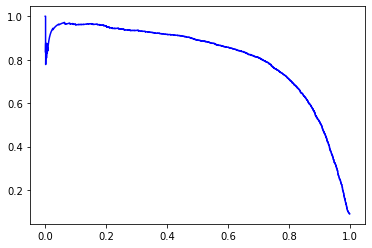

In [30]:
# plot precision over recall
plt.plot(recalls, precisions, 'b-')
plt.show()

In [33]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
print('lowest threshold with precision above 90', threshold_90_precision)

lowest threshold with precision above 90 3370.0194991439566


In [35]:
y_train_90 = (y_scores >= threshold_90_precision)
print(precision_score(ytrain5, y_train_90))
print(recall_score(ytrain5, y_train_90))

0.9000345901072293
0.4799852425751706


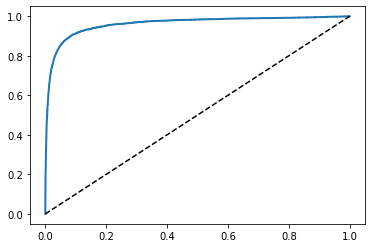

In [36]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(ytrain5, y_scores)
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.show()

In [37]:
from sklearn.metrics import roc_auc_score
roc_auc_score(ytrain5, y_scores)

0.9604938554008616

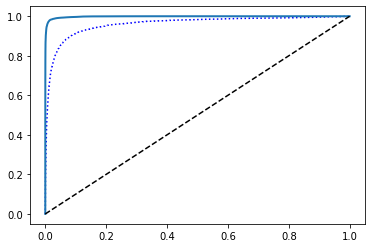

In [39]:
# random forest classifier
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, Xtrain, ytrain5, cv=3, method='predict_proba')


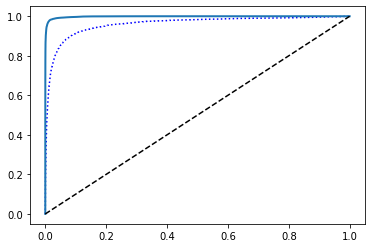

SGD 0.9604938554008616
forest 0.9983436731328145


In [40]:
# roc curve function expects decision scores but it can also take probabilities
y_scores_forest = y_probas_forest[:, 1] # using positive class (5s) probabilities as scores
fpr_forest, tpr_forest, thresholds = roc_curve(ytrain5, y_scores_forest)
plt.plot(fpr, tpr, 'b:', label='SGD')
plt.plot(fpr_forest, tpr_forest, linewidth=2, label='forest')
plt.plot([0, 1], [0, 1], 'k--')
plt.show()

print('SGD', roc_auc_score(ytrain5, y_scores))
print('forest', roc_auc_score(ytrain5, y_scores_forest))

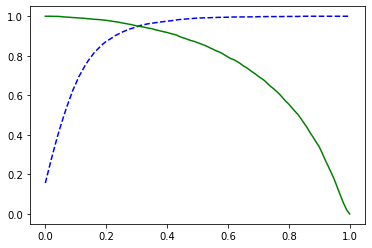

In [44]:
p, r, t = precision_recall_curve(ytrain5, y_scores_forest)
plot_precision_vs_recall(p, r, t)

plt.show()

In [45]:
# multinomial classifier
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(Xtrain, ytrain)
print(svm_clf.predict([some_digit]))

[5]


In [46]:
sgd_clf.fit(Xtrain, ytrain)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [48]:
print(ytrain[0], Xtrain[0])

5 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.  18.
  18.  18. 126. 136. 175.  26. 166. 255. 247. 127.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.  30.  36.  94. 154. 170. 253.
 253. 253. 253. 253. 225. 172. 253. 242. 195.  64.   0.   0.   0.   0.
   0

In [47]:
cross_val_score(sgd_clf, Xtrain, ytrain, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [50]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Xscaled = scaler.fit_transform(Xtrain.astype(np.float64))
cross_val_score(sgd_clf, Xscaled, ytrain, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

In [51]:
ytrainpred = cross_val_predict(sgd_clf, Xscaled, ytrain, cv=3)
matrix = confusion_matrix(ytrain, ytrainpred)
print(matrix)

[[5577    0   22    5    8   43   36    6  225    1]
 [   0 6400   37   24    4   44    4    7  212   10]
 [  27   27 5220   92   73   27   67   36  378   11]
 [  22   17  117 5227    2  203   27   40  403   73]
 [  12   14   41    9 5182   12   34   27  347  164]
 [  27   15   30  168   53 4444   75   14  535   60]
 [  30   15   42    3   44   97 5552    3  131    1]
 [  21   10   51   30   49   12    3 5684  195  210]
 [  17   63   48   86    3  126   25   10 5429   44]
 [  25   18   30   64  118   36    1  179  371 5107]]


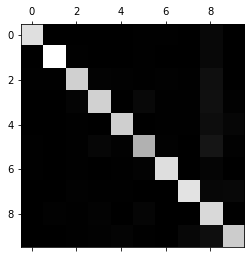

In [52]:
plt.matshow(matrix, cmap=plt.cm.gray)
plt.show()

[[5923]
 [6742]
 [5958]
 [6131]
 [5842]
 [5421]
 [5918]
 [6265]
 [5851]
 [5949]]
[[9.41583657e-01 0.00000000e+00 3.71433395e-03 8.44166807e-04
  1.35066689e-03 7.25983454e-03 6.07800101e-03 1.01300017e-03
  3.79875063e-02 1.68833361e-04]
 [0.00000000e+00 9.49273213e-01 5.48798576e-03 3.55977455e-03
  5.93295758e-04 6.52625334e-03 5.93295758e-04 1.03826758e-03
  3.14446752e-02 1.48323939e-03]
 [4.53172205e-03 4.53172205e-03 8.76132931e-01 1.54414233e-02
  1.22524337e-02 4.53172205e-03 1.12453844e-02 6.04229607e-03
  6.34441088e-02 1.84625713e-03]
 [3.58832164e-03 2.77279400e-03 1.90833469e-02 8.52552602e-01
  3.26211059e-04 3.31104224e-02 4.40384929e-03 6.52422117e-03
  6.57315283e-02 1.19067036e-02]
 [2.05409106e-03 2.39643958e-03 7.01814447e-03 1.54056830e-03
  8.87024991e-01 2.05409106e-03 5.81992468e-03 4.62170490e-03
  5.93974666e-02 2.80725779e-02]
 [4.98063088e-03 2.76701716e-03 5.53403431e-03 3.09905921e-02
  9.77679395e-03 8.19774949e-01 1.38350858e-02 2.58254935e-03
  9.869027

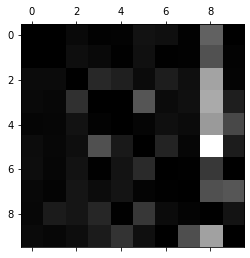

In [55]:
row_sums = matrix.sum(axis=1, keepdims=True)
print(row_sums)
norm_mx = matrix / row_sums
print(norm_mx)
np.fill_diagonal(norm_mx, 0)
plt.matshow(norm_mx, cmap=plt.cm.gray)
plt.show()

NameError: name 'plot_digits' is not defined

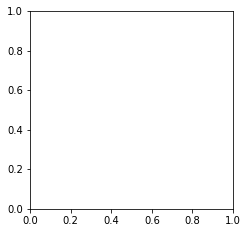

In [57]:
# # plot images
# cla, clb = 3, 5
# Xaa = Xtrain[(ytrain == cla) & (ytrainpred == cla)]
# Xab = Xtrain[(ytrain == cla) & (ytrainpred == clb)]
# Xba = Xtrain[(ytrain == clb) & (ytrainpred == cla)]
# Xbb = Xtrain[(ytrain == clb) & (ytrainpred == clb)]

# plt.figure(figsize=(8,8))
# plt.subplot(221); plot_digits(Xaa[:25], images_per_row=5)
# plt.subplot(222); plot_digits(Xab[:25], images_per_row=5)
# plt.subplot(223); plot_digits(Xba[:25], images_per_row=5)
# plt.subplot(224); plot_digits(Xbb[:25], images_per_row=5)
# plt.show()

In [99]:
# Build classifier with 97% accuracy
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
parameters = {'n_neighbors': [4, 5, 10, 15, 25, 50], 'weights': ['uniform', 'distance']}
clf = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=parameters, cv=3, scoring='accuracy')
clf.fit(Xscaled, ytrain)
# cross_val_score(clf, Xscaled, ytrain, cv=3, scoring='accuracy')

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [4, 5, 10, 15, 25, 50],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [100]:
print(clf.cv_results_)
best = clf.best_params_
print(best)

{'mean_fit_time': array([0.09129008, 0.08159161, 0.08187207, 0.08415731, 0.0819993 ,
       0.08266513, 0.08330512, 0.08525197, 0.08223438, 0.08268317,
       0.08156967, 0.0858682 ]), 'std_fit_time': array([0.01277043, 0.00083971, 0.0015563 , 0.00312843, 0.00073186,
       0.00086088, 0.0012016 , 0.00303849, 0.00081437, 0.00100361,
       0.00033088, 0.00491826]), 'mean_score_time': array([4.8417906 , 4.6090397 , 4.73061164, 4.64982843, 4.71690774,
       4.61822764, 4.74788491, 4.68245165, 4.76747696, 4.63666368,
       4.82862353, 4.90155919]), 'std_score_time': array([0.05990147, 0.02729264, 0.01239572, 0.05604485, 0.01393228,
       0.01821444, 0.01175238, 0.11397112, 0.03153058, 0.02889159,
       0.05311579, 0.18009953]), 'param_n_neighbors': masked_array(data=[4, 4, 5, 5, 10, 10, 15, 15, 25, 25, 50, 50],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False],
       fill_value='?',
            dtype=object), 'pa

In [101]:
knn = KNeighborsClassifier(**best)
knn.fit(Xscaled, ytrain)
Xscaledtest = scaler.fit_transform(Xtest.astype(np.float64))
ypredtest = knn.predict(Xscaledtest)

In [103]:
from sklearn.metrics import accuracy_score, recall_score, precision_score
print(accuracy_score(ytest, ypredtest))
print(precision_score(ytest, ypredtest, average=None))
print(recall_score(ytest, ypredtest, average=None))

0.9474
[0.95247525 0.95755518 0.96207585 0.92507205 0.95571576 0.93273543
 0.96173733 0.93542074 0.9628821  0.92807193]
[0.98163265 0.9938326  0.93410853 0.95346535 0.94501018 0.93273543
 0.97077244 0.92996109 0.90554415 0.92071358]


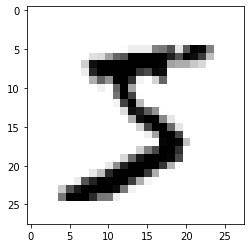

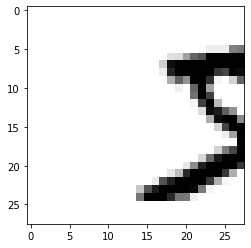

In [133]:
# shift image
def shift_image(image, shape, up_pixels, right_pixels):
    reshaped = image.reshape(shape)
    reshaped = np.roll(reshaped, -up_pixels, axis=0)
    reshaped = np.roll(reshaped, right_pixels, axis=1)
    if up_pixels > 0:
        reshaped[len(image):len(image) - up_pixels, :] = 0.0
    elif up_pixels < 0:
        reshaped[0:-up_pixels, :] = 0.0
    if right_pixels > 0:
        reshaped[:, 0:right_pixels] = 0.0
    elif right_pixels < 0:
        reshaped[:, shape[1] + right_pixels:] = 0.0
    return reshaped.reshape(image.shape)

image = Xtrain[0]
shifted = shift_image(image, (28,28), 0, 10)
plt.imshow(image.reshape(28,28), cmap='binary')
plt.show()
plt.imshow(shifted.reshape(28,28), cmap='binary')
plt.show()


In [138]:
def shift_data(X, shape, up, right):
    return [shift_image(xi, shape, up, right) for xi in X]

Xshifted = scaler.fit_transform(np.concatenate((Xtrain, shift_data(Xtrain, (28,28), 1, 0), shift_data(Xtrain, (28,28), -1, 0), shift_data(Xtrain, (28,28), 0, 1), shift_data(Xtrain, (28,28), 0, -1))).astype(np.float64))
yshifted = np.concatenate((ytrain, ytrain, ytrain, ytrain, ytrain))
print(yshifted.shape, Xshifted.shape)


(300000,) (300000, 784)


In [139]:
knn = KNeighborsClassifier(**best)
knn.fit(Xshifted, yshifted)
ypredtest = knn.predict(Xscaledtest)

In [140]:
print(accuracy_score(ytest, ypredtest))
print(precision_score(ytest, ypredtest, average=None))
print(recall_score(ytest, ypredtest, average=None))

0.9567
[0.96314741 0.95677966 0.96623635 0.94032724 0.96487603 0.93784684
 0.97814776 0.94509804 0.9779978  0.93867458]
[0.98673469 0.99471366 0.94282946 0.96732673 0.95112016 0.94730942
 0.98121086 0.93774319 0.91273101 0.94053518]


In [164]:
# Titanic dataset wrangling
import pandas as pd
df = pd.read_csv('./data/titanic/train.csv')
print(df.columns)
print(df.head)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
<bound method NDFrame.head of      PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily

In [181]:
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

le = LabelEncoder()
df['Sex_Class'] = le.fit_transform(df.Sex)
df['Embarked_Class'] = le.fit_transform(df.Embarked)
df['Imputed_Age'] = df['Age'].fillna(df['Age'].mean())
print(df.columns)
print(df.head)

# imp = SimpleImputer(missing_values=np.nan, strategy='mean')


y = df['Survived'].values
X = df.drop(columns=['Survived', 'Name', 'Ticket', 'Cabin', 'Sex', 'Embarked', 'Age']).values
print(y.shape)
print(X.shape)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Sex_Class',
       'Embarked_Class', 'Imputed_Age'],
      dtype='object')
<bound method NDFrame.head of      PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0  

In [182]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
print(cross_val_score(clf, X, y, cv=3))

[0.81818182 0.7979798  0.83164983]
